In [ ]:
%pip install -q kagglehub imagehash tqdm scikit-learn --upgrade
import kagglehub, zipfile, shutil, random, json, os, re, hashlib, math, itertools
from pathlib import Path
from collections import defaultdict
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# 🛠️ Cell 2 – Handle both *.zip and pre-extracted folder cases
download_path = Path(kagglehub.dataset_download(
    "aryashah2k/breast-ultrasound-images-dataset"))

print("KaggleHub returned:", download_path)

# Decide where the raw BUSI tree should live
# Update raw_root to a writable directory
raw_root = Path("./BUSI_raw")  # Use the current working directory

if download_path.is_file():             # ➜ got a .zip
    if not raw_root.exists():
        zipfile.ZipFile(download_path).extractall(raw_root.parent)
        raw_root = raw_root.parent / download_path.stem   # adjust if zip contains sub-dir
else:                                   # ➜ got a directory (Kaggle kernels, 2nd run, etc.)
    if raw_root.exists(): shutil.rmtree(raw_root)
    shutil.copytree(download_path, raw_root)

print("Raw BUSI directory:", raw_root)
display(list(raw_root.iterdir())[:6])   # peek


KaggleHub returned: /Users/viruzxero/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1
Raw BUSI directory: BUSI_raw


[PosixPath('BUSI_raw/Dataset_BUSI_with_GT')]

In [ ]:
# 🛠️ Cell 3 – Locate the folder that actually contains 'benign', 'malignant', 'normal'
def find_busi_leaf(root: Path) -> Path:
    # Case-1: root itself has the three class dirs
    if all((root / d).is_dir() for d in ('benign', 'malignant', 'normal')):
        return root

    # Case-2: search one level deeper
    for sub in root.iterdir():
        if sub.is_dir() and all((sub / d).is_dir() for d in ('benign', 'malignant', 'normal')):
            return sub

    raise FileNotFoundError("Couldn’t locate BUSI class folders under", root)

data_root = find_busi_leaf(raw_root)
print("Using data_root:", data_root)

def gather_files(root: Path):
    rows = []
    for label_dir in ['benign', 'malignant', 'normal']:
        img_dir = root / label_dir
        for img_path in img_dir.glob("*.png"):
            # --- skip the mask files themselves ---
            if img_path.name.endswith("_mask.png"):
                continue                         # <-- key line
            fname = img_path.name
            mask_path = img_dir / fname.replace(".png", "_mask.png")
            if not mask_path.exists():
                continue                         # some normals have no mask
            rows.append({"file": str(img_path),
                         "mask": str(mask_path),
                         "label": label_dir})
    return pd.DataFrame(rows)


df = gather_files(data_root)

print("Raw counts per class:\n", df["label"].value_counts())
df.head()


Using data_root: BUSI_raw/Dataset_BUSI_with_GT
Raw counts per class:
 label
benign       437
malignant    210
normal       133
Name: count, dtype: int64


,file,mask,label
0,BUSI_raw/Dataset_BUSI_with_GT/benign/benign (3...,BUSI_raw/Dataset_BUSI_with_GT/benign/benign (3...,benign
1,BUSI_raw/Dataset_BUSI_with_GT/benign/benign (2...,BUSI_raw/Dataset_BUSI_with_GT/benign/benign (2...,benign
2,BUSI_raw/Dataset_BUSI_with_GT/benign/benign (1...,BUSI_raw/Dataset_BUSI_with_GT/benign/benign (1...,benign
3,BUSI_raw/Dataset_BUSI_with_GT/benign/benign (8...,BUSI_raw/Dataset_BUSI_with_GT/benign/benign (8...,benign
4,BUSI_raw/Dataset_BUSI_with_GT/benign/benign (3...,BUSI_raw/Dataset_BUSI_with_GT/benign/benign (3...,benign


In [ ]:
df = gather_files(data_root)
print("Image count (after dropping masks):", len(df))   # should be ~780

Image count (after dropping masks): 780


In [ ]:
import imagehash

hash_dict = defaultdict(list)
for i, row in tqdm(df.iterrows(), total=len(df)):
    h = imagehash.phash(Image.open(row.file).resize((128,128)))
    hash_dict[str(h)].append(i)

# any group with >1 index → duplicates
dup_idx = [idx for idxs in hash_dict.values() if len(idxs)>1 for idx in idxs[1:]]  # keep first copy
df_clean = df.drop(index=dup_idx)
print(f"Removed {len(dup_idx)} phash duplicates")

100%|██████████| 780/780 [00:06<00:00, 128.40it/s]


Removed 42 phash duplicates


In [ ]:
# 🛠️ Cell 5 – pull the authors' CSV of flagged images (duplicates, axilla, biopsy)

import requests, io

csv_url = ("https://data.mendeley.com/public-files/datasets/"
           "k8t3gnx9h6/1/files/eb96e4db-9655-44cb-baca-6b0376b5d25a/file_downloaded?download=1")

try:
    resp = requests.get(csv_url, headers={'User-Agent': 'Mozilla/5.0'})
    resp.raise_for_status()                     # throws if 4xx/5xx
    dup_axilla = pd.read_csv(io.BytesIO(resp.content))   # read from bytes buffer
    flag_set = set(dup_axilla.Filename.str.strip())
    df_clean = df_clean[~df_clean.file.str.contains('|'.join(flag_set))]
    print(f"After author-flag removal: {df_clean.shape}")
except Exception as e:
    print("⚠️  Couldn’t fetch CSV –", e)
    print("→ Falling back to manual lists in Cell 6.")


⚠️  Couldn’t fetch CSV – 404 Client Error: Not Found for url: https://data.mendeley.com/public-files/datasets/k8t3gnx9h6/1/files/eb96e4db-9655-44cb-baca-6b0376b5d25a/file_downloaded?download=1
→ Falling back to manual lists in Cell 6.


In [ ]:
AXILLA = {106,166,199,205,207,210,217,218,223,225,228,233,235,236,243,247,248,
          256,257,262,268,292,293,294,296,298,299,306,448,450,545,546,547,550,
          586,637,585,449,617,464,465,498,604,649,686,689,692,695,696,703,705,
          707,709,716,722,730,732,737,738,739,740,741,744,745,747,748,751,754,
          757,765}                       # Table B3
BIOPSY = {506,507,610,611,627,682,776}    # Table B4

def id_from_path(p):                      # e.g., benign (1).png → 1
    return int(re.findall(r'\((\d+)\)', Path(p).stem)[0])

df_clean = df_clean[~df_clean.file.apply(lambda x: id_from_path(x) in AXILLA|BIOPSY)]
print("After axilla/biopsy filter:", df_clean.shape)


After axilla/biopsy filter: (708, 3)


In [ ]:
collision_pairs = {(42,488),(85,489),(131,488),(164,489),(333,514),(333,515),
                   (399,530),(406,531),(433,582),(269,648),(437,681)}  # Table B2
collision_ids = {i for tup in collision_pairs for i in tup}
df_clean = df_clean[~df_clean.file.apply(lambda x: id_from_path(x) in collision_ids)]
print("After removing ambiguous-label images:", df_clean.shape)

After removing ambiguous-label images: (692, 3)


In [ ]:
print(df_clean["label"].value_counts())

label
benign       377
malignant    195
normal       120
Name: count, dtype: int64


In [ ]:
# 🛠️ Cell 8 – Resize, normalise & save to ./BUSI_preproc (robust version)

out_root = Path("./BUSI_preproc")  # Use a local writable directory
out_root.mkdir(exist_ok=True)

def preprocess(img_path: str, size=(256, 256)):
    with Image.open(img_path) as im:
        im = im.convert("L")                 # force 1-channel
        im = im.resize(size, Image.BILINEAR)
        arr = np.asarray(im, np.float32) / 255.0
    return arr

processed = []
for _, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
    img_path  = row["file"]                  # <-- dict-style lookup ⬅️
    mask_path = row["mask"]

    arr       = preprocess(img_path)
    mask_arr  = preprocess(mask_path) if mask_path else np.zeros((256, 256))

    pid = Path(img_path).stem                # e.g. benign (123)

    np.save(out_root / f"{pid}.npy",       arr)
    np.save(out_root / f"{pid}_mask.npy",  mask_arr)

    processed.append({"id": pid, "label": row["label"]})

proc_df = pd.DataFrame(processed)
print("Saved tensors:", len(proc_df))

100%|██████████| 692/692 [00:05<00:00, 122.30it/s]

Saved tensors: 692


In [ ]:
# 🛠️  Cell 8b – make every mask binary (≥0.5 → 1.0 else 0.0)

for _, row in tqdm(proc_df.iterrows(), total=len(proc_df)):
    m_path = out_root / f"{row.id}_mask.npy"
    mask = np.load(m_path)
    mask_bin = (mask >= 0.5).astype(np.float32)
    np.save(m_path, mask_bin)

# verify
vals = {v for _, row in proc_df.iterrows()
            for v in np.unique(np.load(out_root/f"{row.id}_mask.npy"))}
print("After binarisation unique mask values:", vals)


100%|██████████| 692/692 [00:00<00:00, 806.84it/s]


After binarisation unique mask values: {np.float32(0.0), np.float32(1.0)}


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

proc_df["patient"] = proc_df.id.str.extract(r'(\d+)').astype(int)
X = proc_df.index.values
y = proc_df.label.values
groups = proc_df.patient.values

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(sgkf.split(X, y, groups))
val_idx, test_idx = test_idx[:len(test_idx)//2], test_idx[len(test_idx)//2:]

proc_df["split"] = "train"
proc_df.loc[val_idx, "split"] = "val"
proc_df.loc[test_idx, "split"] = "test"
proc_df.split.value_counts()

split
train    559
test      67
val       66
Name: count, dtype: int64

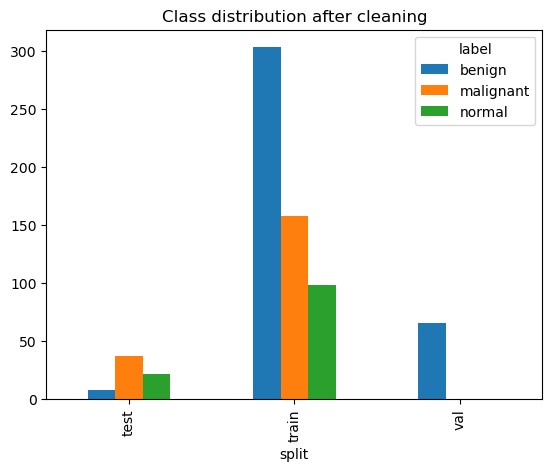

In [ ]:
# Save the metadata CSV to a local writable directory
proc_df.to_csv("./BUSI_clean_metadata.csv", index=False)

# Sanity check class balance
import matplotlib.pyplot as plt
proc_df.groupby(["split", "label"]).size().unstack(1).plot.bar()
plt.title("Class distribution after cleaning")
plt.show()

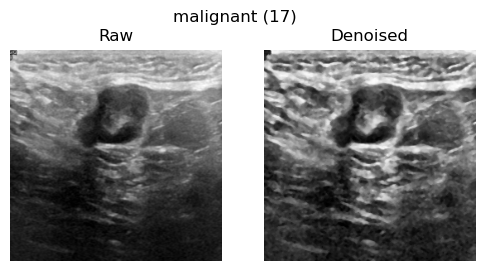

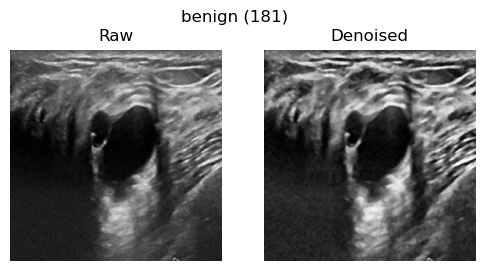

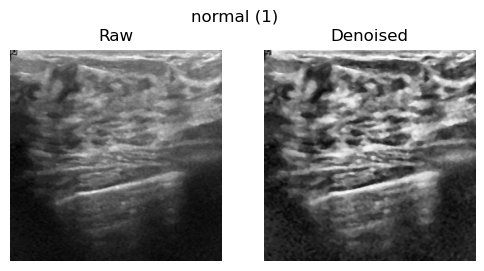

In [ ]:
import cv2

def denoise(arr):
    # Median filter (3×3)
    arr_med = cv2.medianBlur((arr*255).astype(np.uint8), ksize=3)
    # CLAHE contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    arr_eq = clahe.apply(arr_med)
    return arr_eq.astype(np.float32) / 255.0

# Preview before/after on 3 random samples
sample_ids = proc_df.sample(3, random_state=0)["id"]
for sid in sample_ids:
    img = np.load(out_root/f"{sid}.npy")
    img_dn = denoise(img)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title("Raw"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(img_dn, cmap="gray"); plt.title("Denoised"); plt.axis("off")
    plt.suptitle(sid); plt.show()

In [ ]:
# 1️⃣  masks must be binary (0/1)
mask_vals = []
for _, row in proc_df.iterrows():
    m = np.load(out_root/f"{row.id}_mask.npy")
    mask_vals.extend(np.unique(m))

print("Unique values in all masks:", sorted(set(mask_vals)))  # should be [0.0, 1.0]

# 2️⃣  mask and image shapes must match
shapes_ok = all(
    np.load(out_root/f"{row.id}.npy").shape ==
    np.load(out_root/f"{row.id}_mask.npy").shape
    for _, row in proc_df.iterrows())
print("All image/mask shapes identical:", shapes_ok)

Unique values in all masks: [np.float32(0.0), np.float32(1.0)]
All image/mask shapes identical: True


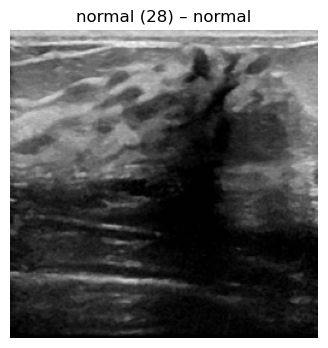

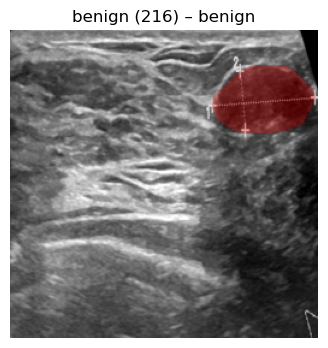

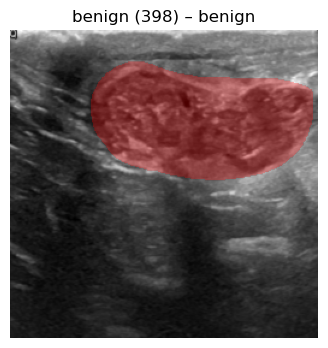

In [ ]:
def show_overlay(pid):
    img  = np.load(out_root/f"{pid}.npy")
    mask = np.load(out_root/f"{pid}_mask.npy")
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray")
    plt.imshow(np.ma.masked_where(mask<0.5, mask), alpha=0.3, cmap="autumn")
    lbl = proc_df.loc[proc_df.id==pid, "label"].values[0]
    plt.title(f"{pid} – {lbl}")
    plt.axis("off")
    plt.show()

for pid in proc_df.sample(3, random_state=1)["id"]:
    show_overlay(pid)

In [ ]:
%pip install -q torch torchvision torchaudio albumentations==1.4.0 pytorch_lightning==2.2.2 --upgrade

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np, pandas as pd, random, os, cv2, math, time
from pathlib import Path
from tqdm import tqdm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
class CFG:
    data_root   = Path("./BUSI_preproc")  # Update to the correct directory
    meta_csv    = Path("./BUSI_clean_metadata.csv")  # Update to the correct directory
    img_size    = 256
    batch_size  = 8
    epochs      = 60
    lr          = 1e-4
    alpha       = 1.0      # segmentation weight
    beta        = 0.5      # classification weight
    num_workers = 0

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: mps


In [ ]:
train_tfms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ElasticTransform(alpha=10, sigma=4, alpha_affine=4, p=0.3),
    A.RandomBrightnessContrast(0.1,0.1,p=0.3),
    ToTensorV2()
])

val_tfms = A.Compose([ToTensorV2()])

In [ ]:
class BUSIDataset(Dataset):
    def __init__(self, df, split):
        self.df = df[df.split==split].reset_index(drop=True)
        self.label_map = {'benign': 0, 'malignant': 1, 'normal': 2}
        self.tfms = train_tfms if split=="train" else val_tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.load(CFG.data_root/f"{row.id}.npy")
        msk = np.load(CFG.data_root/f"{row.id}_mask.npy")

        # albumentations expects HWC
        augmented = self.tfms(image=img[...,None], mask=msk[...,None])
        img_t = augmented["image"].float()          # 1×H×W
        msk_t = augmented["mask"].float()

        label = torch.tensor(self.label_map[row.label], dtype=torch.long)
        return img_t, msk_t, label

In [ ]:
meta = pd.read_csv(CFG.meta_csv)
train_ds = BUSIDataset(meta, "train")
val_ds   = BUSIDataset(meta, "val")
test_ds  = BUSIDataset(meta, "test")

train_dl = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True,
                      num_workers=CFG.num_workers, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=CFG.batch_size, shuffle=False,
                      num_workers=CFG.num_workers, pin_memory=True)

print(f"Train {len(train_ds)} | Val {len(val_ds)} | Test {len(test_ds)}")

Train 559 | Val 66 | Test 67


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self,x): return self.seq(x)

class UNetMulti(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.d1 = DoubleConv(1,   32)
        self.d2 = DoubleConv(32,  64)
        self.d3 = DoubleConv(64, 128)
        self.d4 = DoubleConv(128,256)
        self.bott= DoubleConv(256,512)

        self.maxp = nn.MaxPool2d(2)

        self.u4 = nn.ConvTranspose2d(512,256,2,stride=2)
        self.c4 = DoubleConv(512,256)
        self.u3 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.c3 = DoubleConv(256,128)
        self.u2 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.c2 = DoubleConv(128,64)
        self.u1 = nn.ConvTranspose2d(64,32,2,stride=2)
        self.c1 = DoubleConv(64,32)

        self.seg_head = nn.Conv2d(32, 1, 1)

        # classification head (global avg pool on bottleneck feature map)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.cls_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512,128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128,n_classes)
        )

    def forward(self,x):
        d1 = self.d1(x)
        d2 = self.d2(self.maxp(d1))
        d3 = self.d3(self.maxp(d2))
        d4 = self.d4(self.maxp(d3))
        bt = self.bott(self.maxp(d4))

        u4 = self.u4(bt);  c4 = self.c4(torch.cat([u4,d4],1))
        u3 = self.u3(c4);  c3 = self.c3(torch.cat([u3,d3],1))
        u2 = self.u2(c3);  c2 = self.c2(torch.cat([u2,d2],1))
        u1 = self.u1(c2);  c1 = self.c1(torch.cat([u1,d1],1))

        seg = self.seg_head(c1)
        cls = self.cls_head(self.gap(bt))
        return seg, cls

In [ ]:
bce   = nn.BCEWithLogitsLoss()
ce    = nn.CrossEntropyLoss()

def dice_loss(pred, tgt, eps=1e-7):
    # If pred is logits, apply sigmoid
    if not (0 <= pred.min() and pred.max() <= 1):
        pred = torch.sigmoid(pred)
    num = 2*(pred*tgt).sum((2,3))
    den = pred.sum((2,3)) + tgt.sum((2,3)) + eps
    return 1 - (num/den).mean()

def composite_loss(seg_pred, seg_true, cls_pred, cls_true):
    seg_true = seg_true
    l_seg = 0.5*bce(seg_pred, seg_true) + dice_loss(seg_pred, seg_true)
    l_cls = ce(cls_pred, cls_true)
    return CFG.alpha*l_seg + CFG.beta*l_cls, l_seg, l_cls


In [ ]:
# 🔄 Re-define BUSIDataset with correct mask channel handling
class BUSIDataset(Dataset):
    def __init__(self, df, split):
        self.df = df[df.split==split].reset_index(drop=True)
        self.label_map = {'benign': 0, 'malignant': 1, 'normal': 2}
        self.tfms = train_tfms if split=="train" else val_tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.load(CFG.data_root/f"{row.id}.npy")
        msk = np.load(CFG.data_root/f"{row.id}_mask.npy")

        aug = self.tfms(image=img[...,None], mask=msk[...,None])
        img_t = aug["image"].float()                # 1 x H x W

        msk_t = aug["mask"]
        # --- ensure mask is (1, H, W) ---
        if msk_t.ndim == 2:                         # H x W
            msk_t = msk_t.unsqueeze(0)
        elif msk_t.ndim == 3 and msk_t.shape[0] != 1:  # H x W x 1
            msk_t = msk_t.permute(2, 0, 1)
        msk_t = msk_t.float()

        label = torch.tensor(self.label_map[row.label], dtype=torch.long)
        return img_t, msk_t, label


In [ ]:
train_ds = BUSIDataset(meta, "train")
val_ds   = BUSIDataset(meta, "val")
test_ds  = BUSIDataset(meta, "test")

train_dl = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True,
                      num_workers=CFG.num_workers, pin_memory=torch.cuda.is_available())
val_dl   = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False,
                      num_workers=CFG.num_workers, pin_memory=torch.cuda.is_available())


In [ ]:
model = UNetMulti().to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=3)

best_dice = 0.0
for epoch in range(CFG.epochs):
    model.train()
    tr_loss, n = 0,0
    for img, msk, lbl in tqdm(train_dl, desc=f"Epoch {epoch+1}/{CFG.epochs} – train"):
        img, msk, lbl = img.to(device), msk.to(device), lbl.to(device)
        seg_pred, cls_pred = model(img)
        loss, l_seg, l_cls = composite_loss(seg_pred, msk, cls_pred, lbl)
        opt.zero_grad(); loss.backward(); opt.step()
        tr_loss += loss.item()*img.size(0); n += img.size(0)

    # --- validation
    model.eval(); val_loss=val_dice=0; n=0
    with torch.no_grad():
        for img, msk, lbl in val_dl:
            img, msk, lbl = img.to(device), msk.to(device), lbl.to(device)
            seg_pred, cls_pred = model(img)
            loss, l_seg, l_cls = composite_loss(seg_pred, msk, cls_pred, lbl)
            dice = 1 - dice_loss(seg_pred, msk)
            val_loss += loss.item()*img.size(0)
            val_dice += dice.item()*img.size(0)
            n += img.size(0)
    val_loss /= n; val_dice /= n
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:02d} – Val Dice {val_dice:.4f}")

    # save best by dice
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "./busi_multitask_best.pth")
        print("  ✅ saved best model")


Epoch 1/60 – train: 100%|██████████| 70/70 [00:43<00:00,  1.62it/s]


Epoch 01 – Val Dice 0.1798
  ✅ saved best model


Epoch 2/60 – train: 100%|██████████| 70/70 [00:36<00:00,  1.94it/s]


Epoch 02 – Val Dice 0.2010
  ✅ saved best model


Epoch 3/60 – train: 100%|██████████| 70/70 [00:36<00:00,  1.89it/s]


Epoch 03 – Val Dice 0.2140
  ✅ saved best model


Epoch 4/60 – train: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]


Epoch 04 – Val Dice 0.2103


Epoch 5/60 – train: 100%|██████████| 70/70 [00:53<00:00,  1.31it/s]


Epoch 05 – Val Dice 0.2251
  ✅ saved best model


Epoch 6/60 – train: 100%|██████████| 70/70 [00:53<00:00,  1.30it/s]


Epoch 06 – Val Dice 0.2121


Epoch 7/60 – train: 100%|██████████| 70/70 [00:50<00:00,  1.40it/s]


Epoch 07 – Val Dice 0.2346
  ✅ saved best model


Epoch 8/60 – train: 100%|██████████| 70/70 [00:52<00:00,  1.34it/s]


Epoch 08 – Val Dice 0.2760
  ✅ saved best model


Epoch 9/60 – train: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]


Epoch 09 – Val Dice 0.2845
  ✅ saved best model


Epoch 10/60 – train: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


Epoch 10 – Val Dice 0.2850
  ✅ saved best model


Epoch 11/60 – train: 100%|██████████| 70/70 [00:53<00:00,  1.31it/s]


Epoch 11 – Val Dice 0.2860
  ✅ saved best model


Epoch 12/60 – train: 100%|██████████| 70/70 [00:53<00:00,  1.30it/s]


Epoch 12 – Val Dice 0.2855


Epoch 13/60 – train: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 13 – Val Dice 0.2860
  ✅ saved best model


Epoch 14/60 – train: 100%|██████████| 70/70 [00:51<00:00,  1.35it/s]


Epoch 14 – Val Dice 0.2911
  ✅ saved best model


Epoch 15/60 – train:  23%|██▎       | 16/70 [00:13<00:44,  1.22it/s]


KeyboardInterrupt: 

In [ ]:
# load best
model.load_state_dict(torch.load("./busi_multitask_best.pth"))
model.eval()

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

cls_preds, cls_gts = [],[]
dice_scores = []

with torch.no_grad():
    for img, msk, lbl in DataLoader(test_ds, batch_size=CFG.batch_size):
        img, msk = img.to(device), msk.to(device)
        seg_pred, cls_pred = model(img)

        # Dice
        dice = 1 - dice_loss(seg_pred, msk)
        dice_scores.append(dice.item())

        # classification
        cls_preds.extend(torch.argmax(cls_pred,1).cpu().numpy())
        cls_gts.extend(lbl.numpy())

print(f"Test Dice: {np.mean(dice_scores):.4f}")

acc = accuracy_score(cls_gts, cls_preds)
prec, rec, f1, _ = precision_recall_fscore_support(cls_gts, cls_preds, average='macro')
print(f"Classification – Acc {acc:.3f}  Prec {prec:.3f}  Rec {rec:.3f}  F1 {f1:.3f}")


Test Dice: 0.2402
Classification – Acc 0.657  Prec 0.654  Rec 0.686  F1 0.611


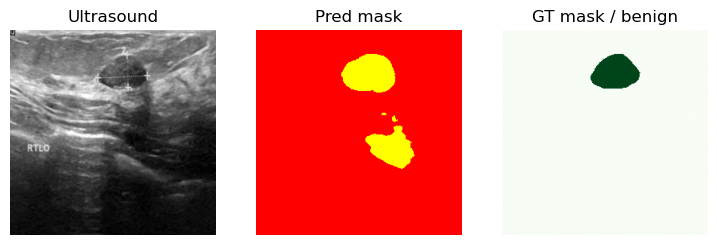

In [ ]:
import matplotlib.pyplot as plt
model.eval()
for img, msk, lbl in DataLoader(test_ds, batch_size=1, shuffle=True):
    img, msk = img.to(device), msk.to(device)
    seg_pred, cls_pred = model(img)
    cls_name = ['benign','malignant','normal'][torch.argmax(cls_pred).item()]

    img_np = img.squeeze().cpu().numpy()
    pred_np = (seg_pred.squeeze().detach().cpu().numpy() > 0.5).astype(np.float32)
    msk_np  = msk.squeeze().cpu().numpy()

    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(img_np,cmap='gray'); plt.title("Ultrasound"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(pred_np,cmap='autumn'); plt.title("Pred mask"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(msk_np,cmap='Greens'); plt.title(f"GT mask / {cls_name}"); plt.axis('off')
    break


In [ ]:
# 🧪 Test the model on a custom image (provide your own image path)

import matplotlib.pyplot as plt

custom_img_path = "PATH/TO/YOUR/IMAGE.png"  # <-- Change this to your image path
custom_mask_path = None  # Optional: path to GT mask if available, else leave as None

def preprocess_custom(img_path, size=(256, 256)):
    from PIL import Image
    import numpy as np
    img = Image.open(img_path).convert("L").resize(size)
    arr = np.asarray(img, np.float32) / 255.0
    return arr

img_arr = preprocess_custom(custom_img_path)
img_tensor = torch.tensor(img_arr).unsqueeze(0).unsqueeze(0).float().to(device)  # 1x1xHxW

model.eval()
with torch.no_grad():
    seg_pred, cls_pred = model(img_tensor)
    pred_mask = (torch.sigmoid(seg_pred).squeeze().cpu().numpy() > 0.5).astype(np.float32)
    cls_name = ['benign','malignant','normal'][torch.argmax(cls_pred).item()]

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(img_arr, cmap='gray'); plt.title("Custom Image"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred_mask, cmap='autumn'); plt.title("Predicted Mask"); plt.axis('off')

if custom_mask_path:
    gt_mask = preprocess_custom(custom_mask_path)
    plt.subplot(1,3,3); plt.imshow(gt_mask, cmap='Greens'); plt.title("GT Mask"); plt.axis('off')
else:
    plt.subplot(1,3,3); plt.axis('off'); plt.title(f"Predicted class: {cls_name}")

plt.suptitle(f"Predicted class: {cls_name}")
plt.show()

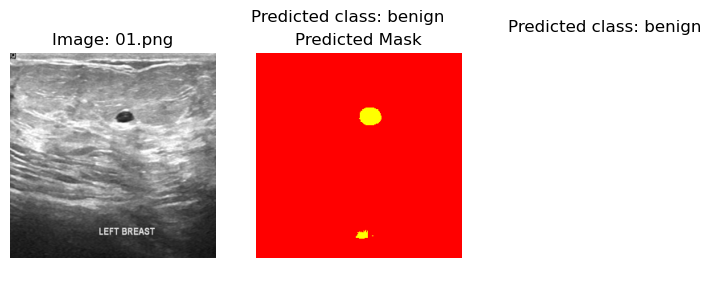

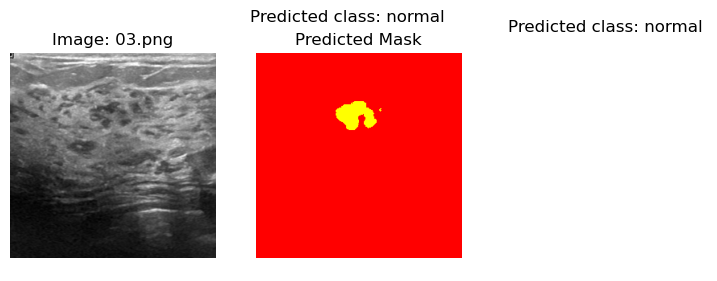

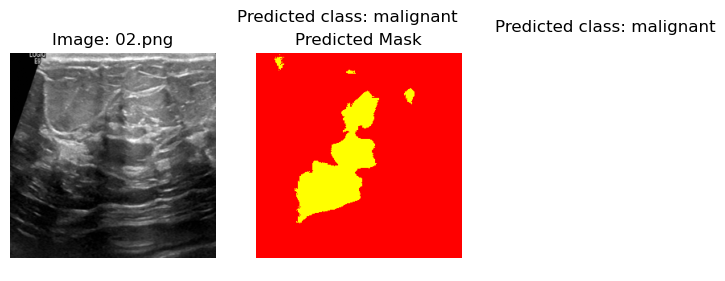

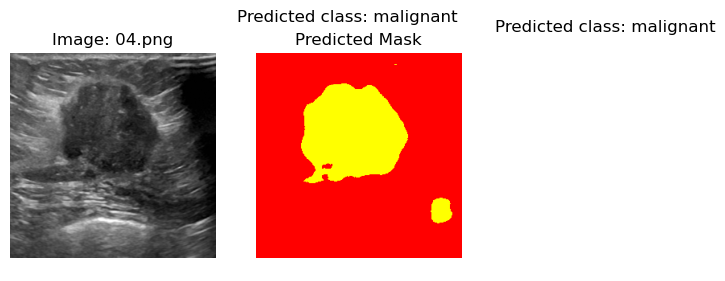

In [ ]:
# 🧪 Test the model on all images in a custom folder

import os
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_custom(img_path, size=(256, 256)):
    img = Image.open(img_path).convert("L").resize(size)
    arr = np.asarray(img, np.float32) / 255.0
    return arr

custom_folder = "/Users/viruzxero/BRACU/CS_ELEC/CSE428_SP25/Project/o4/testimg"  # <-- Change this to your folder path
image_files = [f for f in os.listdir(custom_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for fname in image_files:
    img_path = os.path.join(custom_folder, fname)
    img_arr = preprocess_custom(img_path)
    img_tensor = torch.tensor(img_arr).unsqueeze(0).unsqueeze(0).float().to(device)  # 1x1xHxW

    model.eval()
    with torch.no_grad():
        seg_pred, cls_pred = model(img_tensor)
        pred_mask = (torch.sigmoid(seg_pred).squeeze().cpu().numpy() > 0.5).astype(np.float32)
        cls_name = ['benign','malignant','normal'][torch.argmax(cls_pred).item()]

    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(img_arr, cmap='gray'); plt.title(f"Image: {fname}"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(pred_mask, cmap='autumn'); plt.title("Predicted Mask"); plt.axis('off')
    plt.subplot(1,3,3); plt.axis('off'); plt.title(f"Predicted class: {cls_name}")
    plt.suptitle(f"Predicted class: {cls_name}")
    plt.show()

## Additional Segmentation Metrics: mIoU and Pixel Accuracy
This cell computes and reports mean Intersection over Union (mIoU) and pixel accuracy for the test set, in addition to Dice.

In [ ]:
def compute_miou_and_pixel_acc(preds, gts):
    # preds, gts: list of numpy arrays (binary masks)
    ious = []
    total_correct = 0
    total_pixels = 0
    for pred, gt in zip(preds, gts):
        pred = (pred > 0.5).astype(np.uint8)
        gt = (gt > 0.5).astype(np.uint8)
        intersection = np.logical_and(pred, gt).sum()
        union = np.logical_or(pred, gt).sum()
        iou = intersection / (union + 1e-7)
        ious.append(iou)
        total_correct += (pred == gt).sum()
        total_pixels += pred.size
    miou = np.mean(ious)
    pixel_acc = total_correct / total_pixels
    return miou, pixel_acc

# Collect predictions and GTs for the test set
pred_masks = []
gt_masks = []
with torch.no_grad():
    for img, msk, lbl in DataLoader(test_ds, batch_size=1):
        img, msk = img.to(device), msk.to(device)
        seg_pred, _ = model(img)
        pred_mask = (torch.sigmoid(seg_pred).squeeze().cpu().numpy() > 0.5).astype(np.float32)
        gt_mask = msk.squeeze().cpu().numpy()
        pred_masks.append(pred_mask)
        gt_masks.append(gt_mask)

miou, pixel_acc = compute_miou_and_pixel_acc(pred_masks, gt_masks)
print(f"Test mIoU: {miou:.4f}")
print(f"Test Pixel Accuracy: {pixel_acc:.4f}")

Test mIoU: 0.3401
Test Pixel Accuracy: 0.9308


# Detailed Metrics Output: Segmentation & Classification
This cell computes and prints detailed segmentation and classification metrics for the test set, including Dice, mIoU, pixel accuracy, accuracy, precision, recall, F1, and a full classification report.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / (union + 1e-7)

def evaluate_model(model, test_ds, device):
    model.eval()
    seg_preds = []
    seg_gts = []
    cls_preds = []
    cls_gts = []
    with torch.no_grad():
        for img, msk, lbl in DataLoader(test_ds, batch_size=1):
            img, msk = img.to(device), msk.to(device)
            seg_pred, cls_pred = model(img)
            pred_mask = (torch.sigmoid(seg_pred).squeeze().cpu().numpy() > 0.5).astype(np.uint8)
            gt_mask = msk.squeeze().cpu().numpy().astype(np.uint8)
            seg_preds.append(pred_mask)
            seg_gts.append(gt_mask)
            cls_preds.append(torch.argmax(cls_pred,1).cpu().item())
            cls_gts.append(lbl.item())
    # Flatten masks for pixel metrics
    y_true_flat = np.concatenate([m.flatten() for m in seg_gts])
    y_pred_flat = np.concatenate([m.flatten() for m in seg_preds])
    # Segmentation metrics
    dice = dice_coefficient(y_true_flat, y_pred_flat)
    pixel_acc = pixel_accuracy(y_true_flat, y_pred_flat)
    miou = mean_iou(y_true_flat, y_pred_flat)
    # Classification metrics
    acc = accuracy_score(cls_gts, cls_preds)
    precision = precision_score(cls_gts, cls_preds, average='weighted', zero_division=0)
    recall = recall_score(cls_gts, cls_preds, average='weighted', zero_division=0)
    f1 = f1_score(cls_gts, cls_preds, average='weighted', zero_division=0)
    print("=== Segmentation Metrics ===")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Pixel Accuracy:   {pixel_acc:.4f}")
    print(f"Mean IoU:         {miou:.4f}")
    print("\n=== Classification Metrics ===")
    print(f"Accuracy:         {acc:.4f}")
    print(f"Precision:        {precision:.4f}")
    print(f"Recall:           {recall:.4f}")
    print(f"F1 Score:         {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(cls_gts, cls_preds, target_names=['benign','malignant','normal'], digits=4, zero_division=0))
    print("\nConfusion Matrix:")
    print(confusion_matrix(cls_gts, cls_preds))

# Run on test set
print("=== Test Metrics ===")
evaluate_model(model, test_ds, device)

=== Test Metrics ===
=== Segmentation Metrics ===
Dice Coefficient: 0.6298
Pixel Accuracy:   0.9308
Mean IoU:         0.4597

=== Classification Metrics ===
Accuracy:         0.6567
Precision:        0.7520
Recall:           0.6567
F1 Score:         0.6708

Classification Report:
              precision    recall  f1-score   support

      benign     0.3333    0.8750    0.4828         8
   malignant     0.7941    0.7297    0.7606        37
      normal     0.8333    0.4545    0.5882        22

    accuracy                         0.6567        67
   macro avg     0.6536    0.6864    0.6105        67
weighted avg     0.7520    0.6567    0.6708        67


Confusion Matrix:
[[ 7  1  0]
 [ 8 27  2]
 [ 6  6 10]]
=== Segmentation Metrics ===
Dice Coefficient: 0.6298
Pixel Accuracy:   0.9308
Mean IoU:         0.4597

=== Classification Metrics ===
Accuracy:         0.6567
Precision:        0.7520
Recall:           0.6567
F1 Score:         0.6708

Classification Report:
              precisio

# Detailed Metrics Output: Segmentation & Classification (Train & Test)
This cell computes and prints detailed segmentation and classification metrics for both the training and test sets, and visualizes good and challenging segmentation cases from the test set.

=== Training Metrics ===
=== Train Segmentation Metrics ===
Dice Coefficient: 0.6417
Pixel Accuracy:   0.9382
Mean IoU:         0.4725

=== Train Classification Metrics ===
Accuracy:         0.7871
Precision:        0.7883
Recall:           0.7871
F1 Score:         0.7876

Classification Report:
              precision    recall  f1-score   support

      benign     0.8378    0.8185    0.8280       303
   malignant     0.7081    0.7215    0.7147       158
      normal     0.7647    0.7959    0.7800        98

    accuracy                         0.7871       559
   macro avg     0.7702    0.7786    0.7743       559
weighted avg     0.7883    0.7871    0.7876       559


Confusion Matrix:
[[248  39  16]
 [ 36 114   8]
 [ 12   8  78]]

=== Test Metrics ===
=== Train Segmentation Metrics ===
Dice Coefficient: 0.6417
Pixel Accuracy:   0.9382
Mean IoU:         0.4725

=== Train Classification Metrics ===
Accuracy:         0.7871
Precision:        0.7883
Recall:           0.7871
F1 Score:   

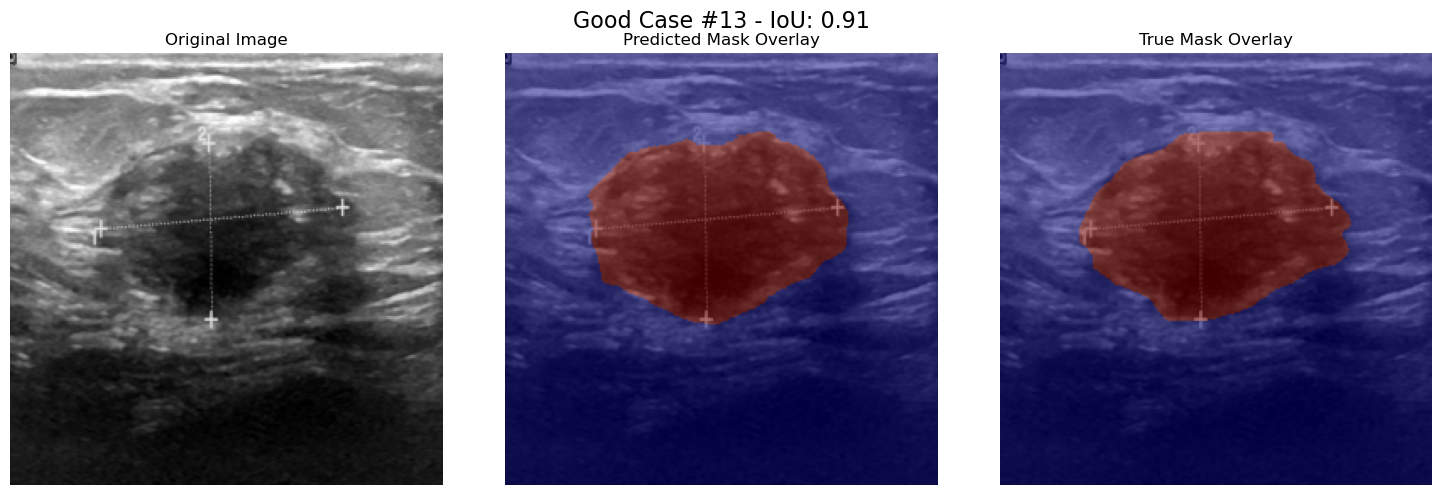

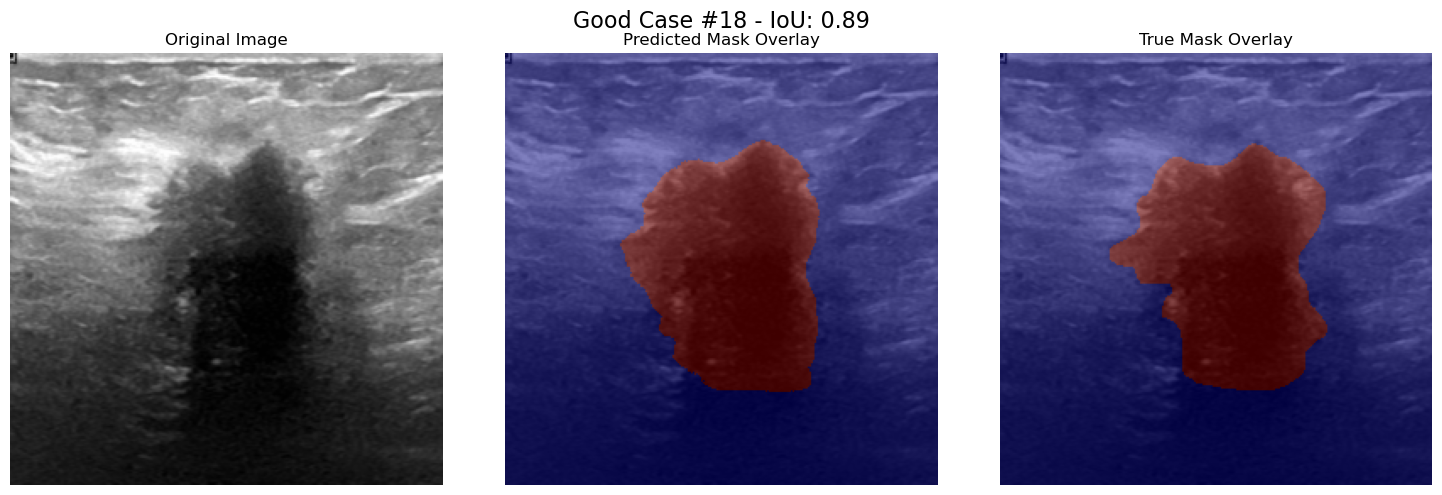

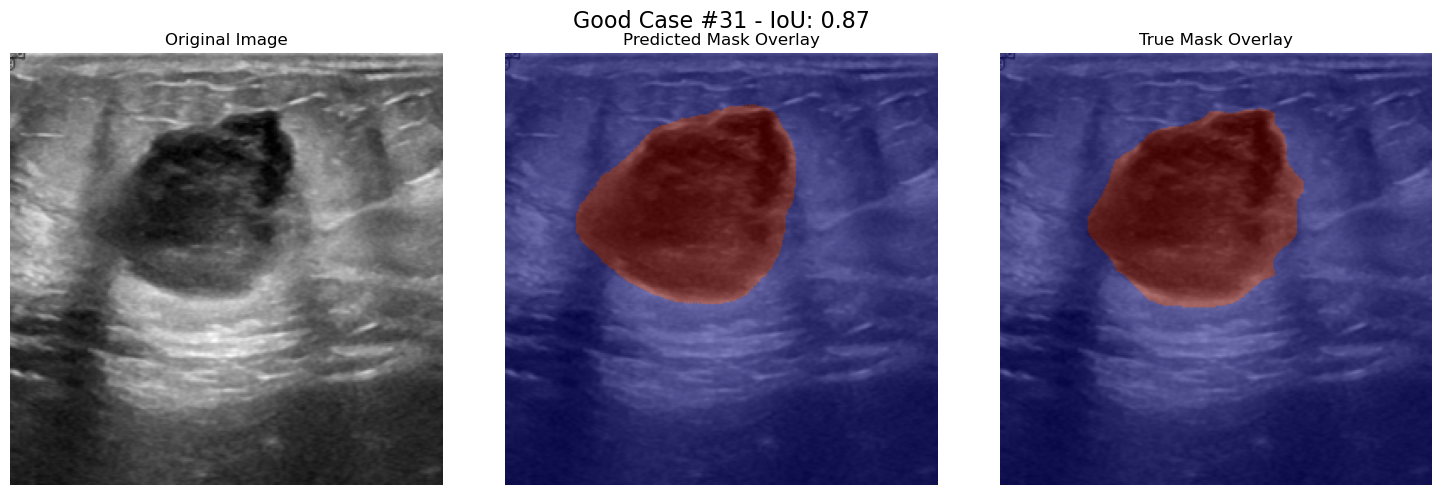


--- Challenging Segmentation Cases (Low IoU) ---


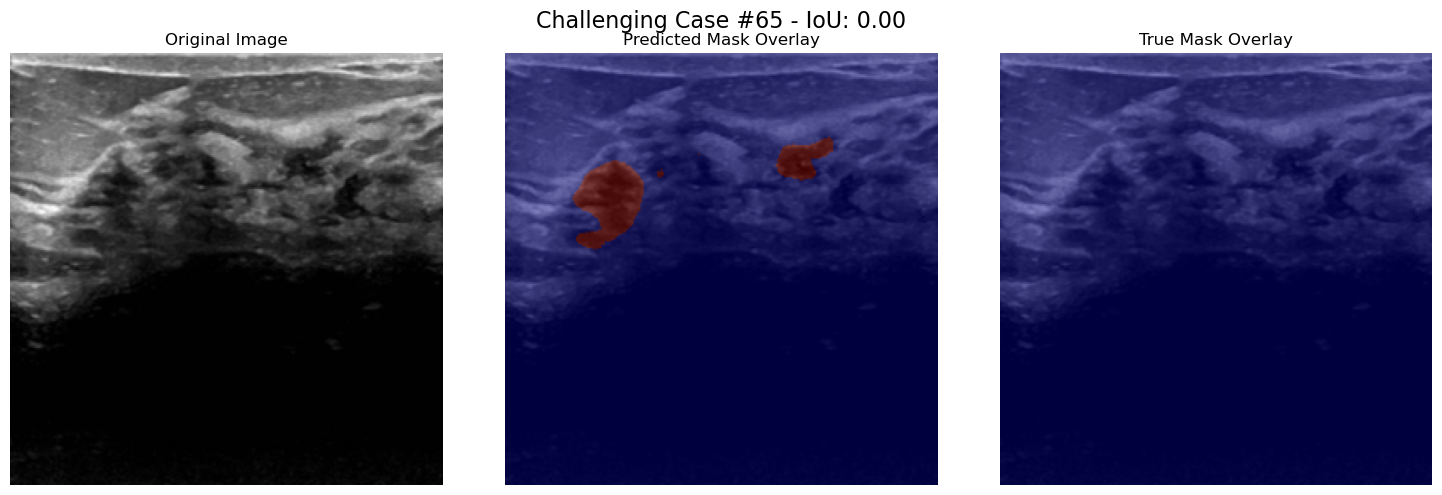

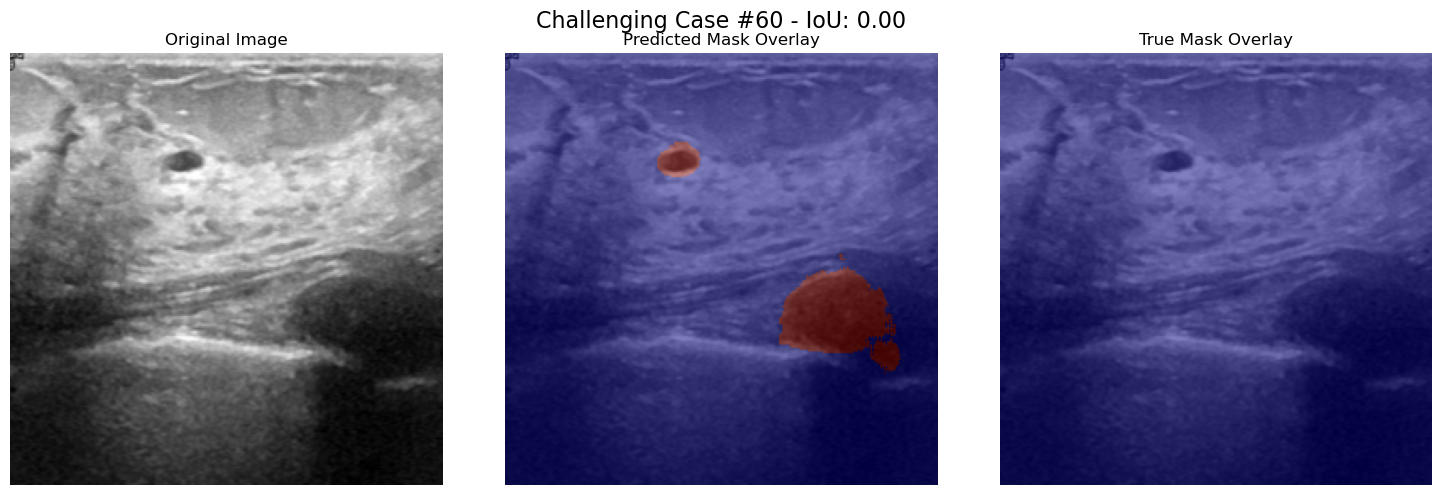

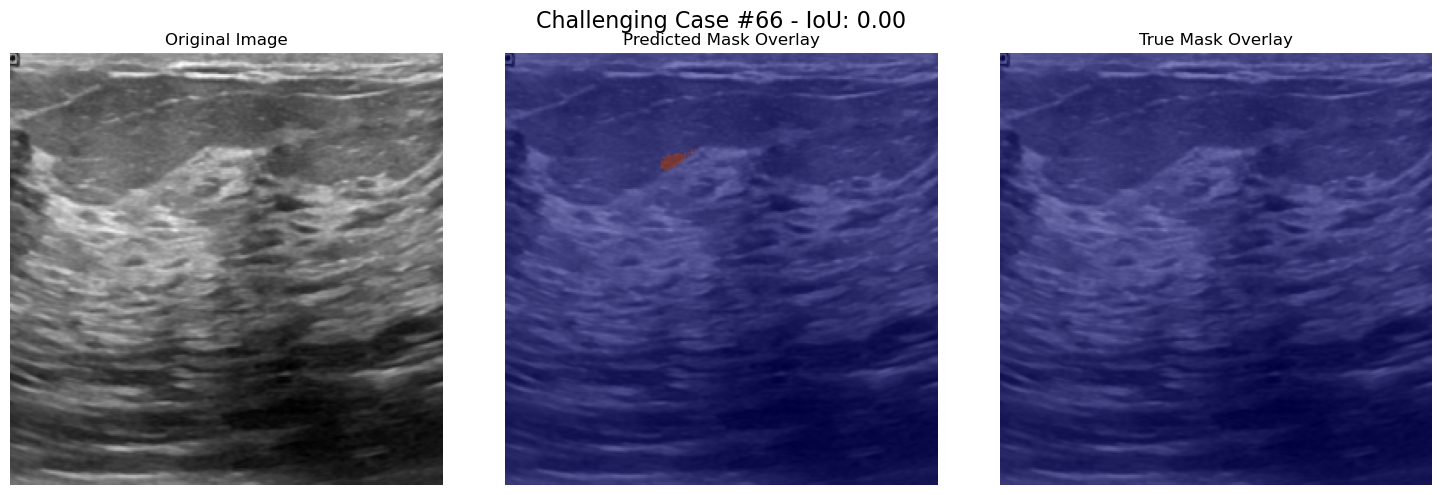

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / (union + 1e-7)

def evaluate_model(model, dataset, device, set_name="Test"):
    model.eval()
    seg_preds = []
    seg_gts = []
    cls_preds = []
    cls_gts = []
    orig_imgs = []
    with torch.no_grad():
        for img, msk, lbl in DataLoader(dataset, batch_size=1):
            img, msk = img.to(device), msk.to(device)
            seg_pred, cls_pred = model(img)
            pred_mask = (torch.sigmoid(seg_pred).squeeze().cpu().numpy() > 0.5).astype(np.uint8)
            gt_mask = msk.squeeze().cpu().numpy().astype(np.uint8)
            seg_preds.append(pred_mask)
            seg_gts.append(gt_mask)
            cls_preds.append(torch.argmax(cls_pred,1).cpu().item())
            cls_gts.append(lbl.item())
            orig_imgs.append(img.squeeze().cpu().numpy())
    y_true_flat = np.concatenate([m.flatten() for m in seg_gts])
    y_pred_flat = np.concatenate([m.flatten() for m in seg_preds])
    dice = dice_coefficient(y_true_flat, y_pred_flat)
    pixel_acc = pixel_accuracy(y_true_flat, y_pred_flat)
    miou = mean_iou(y_true_flat, y_pred_flat)
    acc = accuracy_score(cls_gts, cls_preds)
    precision = precision_score(cls_gts, cls_preds, average='weighted', zero_division=0)
    recall = recall_score(cls_gts, cls_preds, average='weighted', zero_division=0)
    f1 = f1_score(cls_gts, cls_preds, average='weighted', zero_division=0)
    print(f"=== {set_name} Segmentation Metrics ===")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Pixel Accuracy:   {pixel_acc:.4f}")
    print(f"Mean IoU:         {miou:.4f}")
    print(f"\n=== {set_name} Classification Metrics ===")
    print(f"Accuracy:         {acc:.4f}")
    print(f"Precision:        {precision:.4f}")
    print(f"Recall:           {recall:.4f}")
    print(f"F1 Score:         {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(cls_gts, cls_preds, target_names=['benign','malignant','normal'], digits=4, zero_division=0))
    print("\nConfusion Matrix:")
    print(confusion_matrix(cls_gts, cls_preds))
    return orig_imgs, seg_preds, seg_gts

def calculate_iou(pred_mask, true_mask):
    pred_mask_bool = pred_mask.astype(bool)
    true_mask_bool = true_mask.astype(bool)
    intersection = np.sum(pred_mask_bool & true_mask_bool)
    union = np.sum(pred_mask_bool | true_mask_bool)
    iou = intersection / union if union != 0 else 0
    return iou

def visualize_overlay(original_image, predicted_mask, true_mask, title):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(original_image.squeeze(), cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    ax[1].imshow(original_image.squeeze(), cmap='gray')
    ax[1].imshow(predicted_mask.squeeze(), cmap='jet', alpha=0.5)
    ax[1].set_title("Predicted Mask Overlay")
    ax[1].axis('off')
    ax[2].imshow(original_image.squeeze(), cmap='gray')
    ax[2].imshow(true_mask.squeeze(), cmap='jet', alpha=0.5)
    ax[2].set_title("True Mask Overlay")
    ax[2].axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Evaluate on training set
print("=== Training Metrics ===")
train_imgs, train_preds, train_gts = evaluate_model(model, train_ds, device, set_name="Train")

# Evaluate on test set
print("\n=== Test Metrics ===")
test_imgs, test_preds, test_gts = evaluate_model(model, test_ds, device, set_name="Test")

# Good and Challenging Cases Visualization (on test set)
ious = [calculate_iou(p, g) for p, g in zip(test_preds, test_gts)]
sorted_indices = np.argsort(ious)[::-1]
good_cases = sorted_indices[:3]
bad_cases = sorted_indices[-3:]

print("\n--- Good Segmentation Cases (High IoU) ---")
for idx in good_cases:
    visualize_overlay(test_imgs[idx], test_preds[idx], test_gts[idx], f"Good Case #{idx} - IoU: {ious[idx]:.2f}")

print("\n--- Challenging Segmentation Cases (Low IoU) ---")
for idx in bad_cases:
    visualize_overlay(test_imgs[idx], test_preds[idx], test_gts[idx], f"Challenging Case #{idx} - IoU: {ious[idx]:.2f}")